### In MODULE three,
This is where all the bulk analysis is going to be. In high_mag_analysis.py, there are a number of classes and functions that will help you with parsing the data into meaningful graphs. This MODULE assumes the existence of the video_info.json files that are generated partly in MODULE 1.

### Below code:
Are just import statements

In [1]:
from IPython.display import clear_output
import re
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.development.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.development.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis
)
import sys
import os
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
from tqdm import tqdm
import scipy
import matplotlib as mpl
from pathlib import Path
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
import dropbox
from amftrack.util.dbx import upload_folder, download, read_saved_dropbox_state, save_dropbox_state, load_dbx, get_dropbox_folders, get_dropbox_video_folders, download_video_folders_drop, download_analysis_folders_drop
from subprocess import call
import logging
import datetime
import glob
import json
from amftrack.pipeline.launching.run_super import run_parallel_flows

%matplotlib widget
%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams['figure.dpi'] = 200


/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-08-24 15:49:14.104093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 15:49:14.340100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:

## File declaration
As this notebook is designed to work with Snellius (now also on a local computer!), two items to separate are the raw video files and the analysis. The raw video files are large, bulky and not so easy to flip through. Ideally, the video files would be downloaded and the analysis would be stored on a separate folder structure entirely. That way, large scale analysis of analysis folders can happen when there are thousands of videos in the dataset, without having to have those raw video folders on hand.

Below function will basically make your folders fertile ground to accept all the video info folders and raw video files.

### Input:
Please give separately the folder where raw video data is stored, and where the analysis will be stored. Also give the dropbox address of the dataset you want to analyze.

### Output:
The specified dropbox folder will be looked through, and all relevant video information will be downloaded to an analysis folder structure identical to what is present on teh dropbox. The relevant raw video folder structure will also be generated, if specified so. Will also create cache files in the form of .json files such that next time, the scrounging does not have to happen.

In [4]:
# videos_folder = "E:\\AMOLF_Data\\videos\\"
# analysis_folder = "E:\\AMOLF_Data\\analysis\\"

videos_folder = "/gpfs/scratch1/shared/amftrackflow/videos/"
analysis_folder = "/gpfs/home6/svstaalduine/Analysis/"

# dropbox_address = "/DATA/FLUORESCENCE/DATA_NileRed/"
# dropbox_address=  "/DATA/MYRISTATE/DATA/2_weeks"
# dropbox_address = "/DATA/TransportROOT/DATA/"
dropbox_address = "/DATA/CocoTransport/"
# dropbox_address = "/DATA/TRANSPORT/DATA/20230308_Plate070/"

# Module 3: Bulk Analysis
## First part: Assemble Edge DataFrame


In this initial part of the bulk analysis, all of the analysis folders will be looked through to find the edge data we're looking for. Additionally, there is an optional part to download the analysis folder back to the analysis folder we specified right at the top.

## Assuming all the analysis folders are already downloaded:
You can use below code to read the video_data.json files that are created during indexing of all the videos

In [5]:
folder_filter = dropbox_address[5:]

img_infos = glob.glob(f"{analysis_folder}{folder_filter}/**/video_data.json", recursive=True)
vid_anls_frame = pd.DataFrame()
for address in tqdm(img_infos):
    add_info = pd.read_json(address, orient='index').T
    vid_anls_frame = pd.concat([vid_anls_frame, add_info], ignore_index=True)

vid_frame = vid_anls_frame.sort_values('unique_id').reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2558/2558 [00:05<00:00, 427.19it/s]


In [6]:
####################################################################################
### This is where you can apply the filters. Only those videos will be analyzed. ###
####################################################################################
analysis_frame=vid_frame.copy()

analysis_frame = analysis_frame[analysis_frame['imaging_day'].ge("20230804")].reset_index(drop=True)
analysis_frame['plate_int'] = [entry.split('_')[-1] for entry in analysis_frame['plate_id']]
analysis_frame['video_int'] = [entry.split('_')[-1] for entry in analysis_frame['unique_id']]
analysis_frame = analysis_frame[analysis_frame['xpos'].le(100)].reset_index(drop=True)
# analysis_frame = analysis_frame[analysis_frame['plate_int'] == "Plate440"].reset_index(drop=True)
# analysis_frame = analysis_frame[analysis_frame['mode'] == "F"].reset_index(drop=True)

####################################################################################
### Below code will prepare for those videos to be downloaded to videos_folder.  ###
####################################################################################
analysis_frame

,imaging_day,storage_path,plate_id,root,strain,treatment,crossing_day,video_int,time_(s),mode,...,zpos,unique_id,folder,tot_path_drop,record_time,days_after_crossing,magnification,analysis_folder,videos_folder,plate_int
0,20230804,Dropbox\DATA\CocoTransport,20230804_Plate454,Carrot,C2,001P100N100C,20230730,001,30.0,F,...,13.458,20230804_Plate454_001,CocoTransport/20230804_Plate454/001/Img,DATA/CocoTransport/20230804_Plate454/001/Img,10:23:06,5,4.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate454
1,20230804,Dropbox\DATA\CocoTransport,20230804_Plate454,Carrot,C2,001P100N100C,20230730,002,30.0,BF,...,12.094,20230804_Plate454_002,CocoTransport/20230804_Plate454/002/Img,DATA/CocoTransport/20230804_Plate454/002/Img,10:34:01,5,50.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate454
2,20230804,Dropbox\DATA\CocoTransport,20230804_Plate454,Carrot,C2,001P100N100C,20230730,003,30.0,F,...,12.094,20230804_Plate454_003,CocoTransport/20230804_Plate454/003/Img,DATA/CocoTransport/20230804_Plate454/003/Img,10:34:58,5,50.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate454
3,20230804,Dropbox\DATA\CocoTransport,20230804_Plate454,Carrot,C2,001P100N100C,20230730,004,30.0,BF,...,12.106,20230804_Plate454_004,CocoTransport/20230804_Plate454/004/Img,DATA/CocoTransport/20230804_Plate454/004/Img,10:39:45,5,50.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate454
4,20230804,Dropbox\DATA\CocoTransport,20230804_Plate454,Carrot,C2,001P100N100C,20230730,005,30.0,F,...,12.106,20230804_Plate454_005,CocoTransport/20230804_Plate454/005/Img,DATA/CocoTransport/20230804_Plate454/005/Img,10:40:33,5,50.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,20230816,Dropbox\DATA\CocoTransport,20230816_Plate449,Carrot,C2,001P100N100C,20230807,215,10.0,F,...,11.678,20230816_Plate449_215,CocoTransport/20230816_Plate449/215/Img,DATA/CocoTransport/20230816_Plate449/215/Img,15:27:19,9,50.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate449
1586,20230816,Dropbox\DATA\CocoTransport,20230816_Plate449,Carrot,C2,001P100N100C,20230807,216,10.0,BF,...,11.653,20230816_Plate449_216,CocoTransport/20230816_Plate449/216/Img,DATA/CocoTransport/20230816_Plate449/216/Img,15:28:10,9,50.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate449
1587,20230816,Dropbox\DATA\CocoTransport,20230816_Plate449,Carrot,C2,001P100N100C,20230807,217,10.0,F,...,11.653,20230816_Plate449_217,CocoTransport/20230816_Plate449/217/Img,DATA/CocoTransport/20230816_Plate449/217/Img,15:28:23,9,50.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate449
1588,20230816,Dropbox\DATA\CocoTransport,20230816_Plate449,Carrot,C2,001P100N100C,20230807,218,10.0,BF,...,11.761,20230816_Plate449_218,CocoTransport/20230816_Plate449/218/Img,DATA/CocoTransport/20230816_Plate449/218/Img,15:29:16,9,50.0,/gpfs/home6/svstaalduine/Analysis/CocoTranspor...,/gpfs/scratch1/shared/amftrackflow/videos/Coco...,Plate449


In [7]:
data_obj = HighmagDataset(analysis_frame, analysis_folder, videos_folder)

Couldn't find the edges data file. Check analysis for 20230806_Plate452_019
Couldn't find the edges data file. Check analysis for 20230806_Plate452_021
Couldn't find the edges data file. Check analysis for 20230806_Plate452_029
Couldn't find the edges data file. Check analysis for 20230806_Plate452_051
Couldn't find the edges data file. Check analysis for 20230806_Plate452_053
Couldn't find the edges data file. Check analysis for 20230806_Plate454_007
Couldn't find the edges data file. Check analysis for 20230806_Plate454_011
Couldn't find the edges data file. Check analysis for 20230806_Plate454_030
Couldn't find the edges data file. Check analysis for 20230806_Plate454_034
Couldn't find the edges data file. Check analysis for 20230806_Plate454_038
Couldn't find the edges data file. Check analysis for 20230807_Plate426_005
Couldn't find the edges data file. Check analysis for 20230807_Plate426_010
Couldn't find the edges data file. Check analysis for 20230809_Plate426_001
Couldn't fin

### Example code Fourier Analysis


In [10]:
test_obj = data_obj.filter_edges("video_int", "<=", "4")


### Example code for creating different plate maps
Below you can see the filtering options for different plates and the plot_plate_locs function that outputs a map with dots or arrows depending on your wishes. Current drawing modes are:
- 'scatter' for dots of the videos, separated by magnification
- 'speeds_mean' for black arrows denoting the effective mean speed of the flows
- 'speeds_both' for blue and orange arrows denoting the effective speed of flows in both directions
- 'flux_mean'   for black arrows pointing to the flux direction. Calculated flux is divided by 100
- 'vid_labels'  for a list of what videos were taken at each position

spd_thresh is a parameter you can set to make speeds below it appear as dots

In [ ]:
plt.close('all')
mpl.rcParams['figure.dpi'] =500
print(data_obj.video_frame.columns)

for plate_id in tqdm(data_obj.video_frame['plate_id'].unique()):
    plate_group = data_obj.filter_edges('coverage_tot', '>=', 0.3)
    plate_group = data_obj.filter_edges('plate_id', '==', plate_id)
    if len(plate_group.video_frame) <= 1:
        continue
    else:
        plate_group.plot_plate_locs(analysis_folder, spd_thresh=3.4, modes=['speeds_both'])

mpl.rcParams['figure.dpi'] = 200


### Example code 50x speed arrows

In [ ]:
plt.close('all')
data_interest = data_obj.filter_edges('video_int', ">=", "000")
data_interest = data_obj.filter_edges('video_int', ">=", "006")
data_interest = data_interest.filter_edges('video_int', "<=", "032")
data_interest = data_interest.filter_edges('imaging_day', "==", "20230727")

for vid_obj in tqdm(data_interest.video_objs):
    vid_obj.plot_speed_arrows(plot_both=True, save_im=True, video_txt_size=30)

### Example code plot summaries of videos


In [ ]:
data_obj_filt = data_obj.filter_edges("imaging_day", "==", "20230806")
data_obj_filt = data_obj_filt.filter_edges("video_int", ">=", "009")
data_obj_filt = data_obj_filt.filter_edges("video_int", "<=", "011")

print(len(data_obj_filt.edges_frame))
for edge in data_obj_filt.edge_objs:
    edge.show_summary()

In [ ]:
data_obj_BF = data_obj.filter_edges("mode", "==", "BF")
data_obj_FL = data_obj.filter_edges("mode", "==", "F")

fig, ax = plt.subplots(1,2)

for i, day in enumerate(data_obj_BF.edges_frame['imaging_day'].unique()):
    data_BF_filt = data_obj_BF.filter_edges("imaging_day", "==", day)
    data_FL_filt = data_obj_FL.filter_edges("imaging_day", "==", day)

    ax[i].set_title(f"Data for {day}")
    ax[i].scatter(data_BF_filt.edges_frame['video_int'].astype(int), data_BF_filt.edges_frame['speed_left'], alpha=0.7, c='tab:orange', label='BF')
    ax[i].scatter(data_BF_filt.edges_frame['video_int'].astype(int), data_BF_filt.edges_frame['speed_right'], alpha=0.7, c='tab:orange')
    ax[i].scatter(data_FL_filt.edges_frame['video_int'].astype(int), data_FL_filt.edges_frame['speed_left'], alpha=0.7, c='tab:blue', label='F')
    ax[i].scatter(data_FL_filt.edges_frame['video_int'].astype(int), data_FL_filt.edges_frame['speed_right'], alpha=0.7, c='tab:blue')
    ax[i].set_xlabel("Video nr")
    ax[i].set_ylabel("Velocity $(\mu m/s)$")
    ax[i].axhline(c='black', linestyle='--')
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-7, 7])
fig.tight_layout()

In [ ]:
data_obj.edges_frame.columns

### Example code binned violin-plot
bin-column represents the value to be binned, then multiple violin plots are graphed on the same axis.

752


/home/svstaalduine/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/gpfs/home6/svstaalduine/AMF_project/amftrack/pipeline/development/high_mag_videos/high_mag_analysis.py:630: RuntimeWarning: Mean of empty slice
  violin_means = [np.nanmean(data, axis=0) for data in violin_data_d]


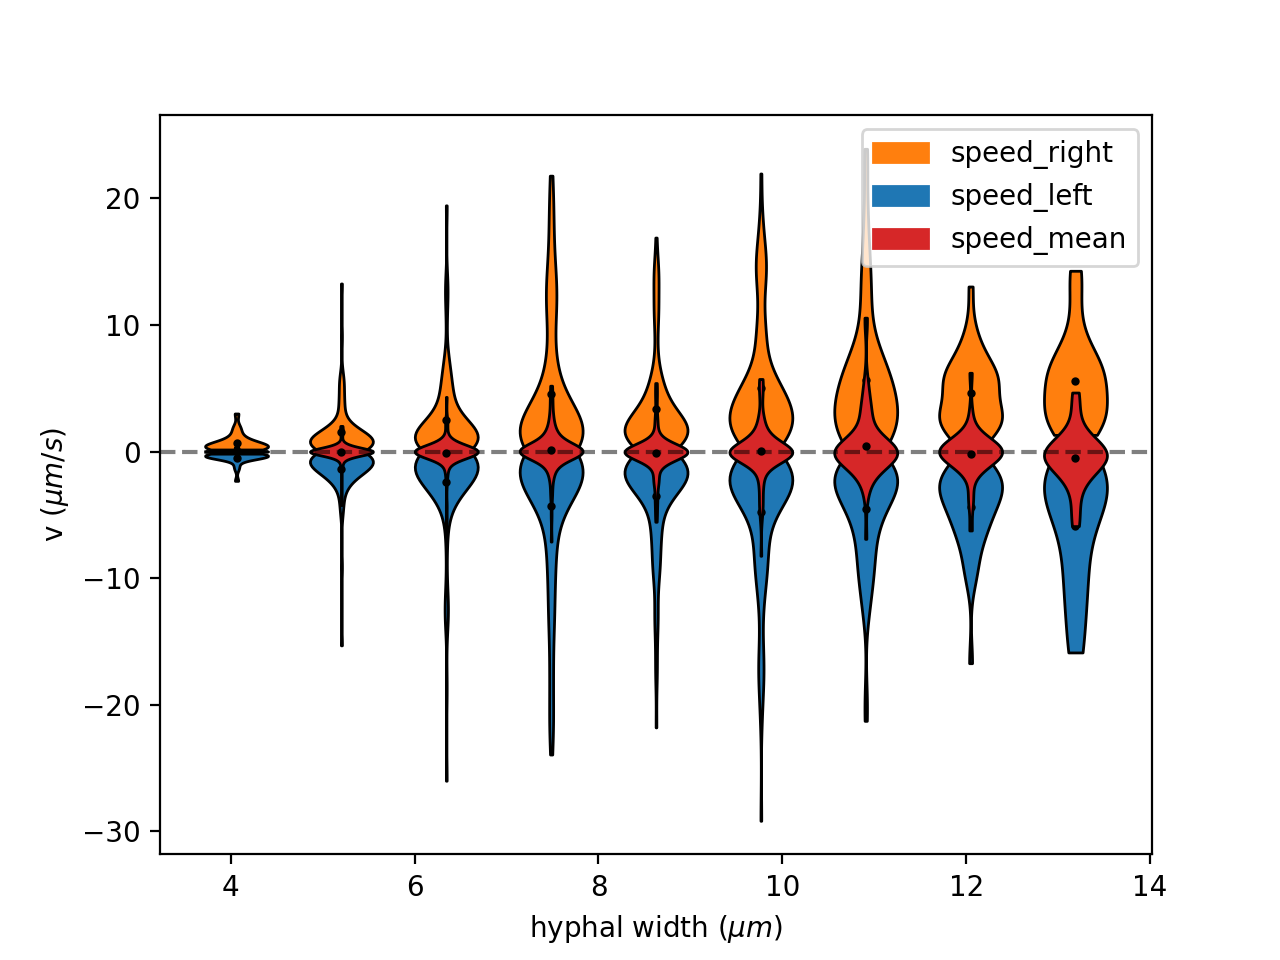

In [14]:
cover_filter_data = data_obj.filter_edges('coverage_tot', '>=', 0.5)
filter_BF = cover_filter_data.filter_edges('mode', '==', 'BF')
# filter_BF = filter_BF.filter_edges('imaging_day', '>=', '20230728')
# filter_BF = cover_filter_data
print(len(filter_BF.edges_frame))
bin_column = 'edge_width'

# bins = np.linspace(5, 15, 10)
bins = np.linspace(filter_BF.return_edge_frame()[bin_column].min(), filter_BF.return_edge_frame()[bin_column].max(), 10)
bin_series = filter_BF.bin_values(bin_column, bins)
# print(bin_series)

labels = []
fig, ax = filter_BF.plot_violins('speed_right', bins, c='tab:orange', labels=labels)
fig, ax = filter_BF.plot_violins('speed_left', bins, c='tab:blue', ax=ax, fig=fig, labels=labels)
fig, ax = filter_BF.plot_violins('speed_mean', bins, c='tab:red', ax=ax, fig=fig, labels=labels)

ax.axhline(c='black', alpha=0.5, linestyle='--')
ax.set_ylabel('v $(\mu m / s)$')
ax.set_xlabel('hyphal width $(\mu m)$')
ax.legend(*zip(*labels))
